In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge

## Задание 3

In [2]:
M_values = range(16)  # Значения степени полинома от 0 до 15
functions = [
    lambda x: np.cos(x),
    lambda x: 5 * x**3 + x**2 + 5,
    lambda x: x * np.sin(x)
]
function_labels = [
    "y = cos(x)",
    "y = 5x^3 + x^2 + 5",
    "y = x * sin(x)"
]

In [4]:
def generate_samples(function, noise_type="uniform", num_samples=100, x_range=(0, 2 * np.pi)):
    x = np.random.uniform(x_range[0], x_range[1], num_samples)
    y = function(x)

    if noise_type == "uniform":
        noise = np.random.uniform(-0.5, 0.5, num_samples)  # Равномерный шум
    elif noise_type == "normal":
        noise = np.random.normal(0, 0.5, num_samples)  # Нормальный шум
    else:
        raise ValueError("Выберите: uniform / normal")

    y_noisy = y + noise
    return x, y_noisy

In [5]:
# Полиномиальная регрессия методом наименьших квадратов
def polynomial_regression(x, y, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x[:, np.newaxis])
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    return y_pred, model, X_poly

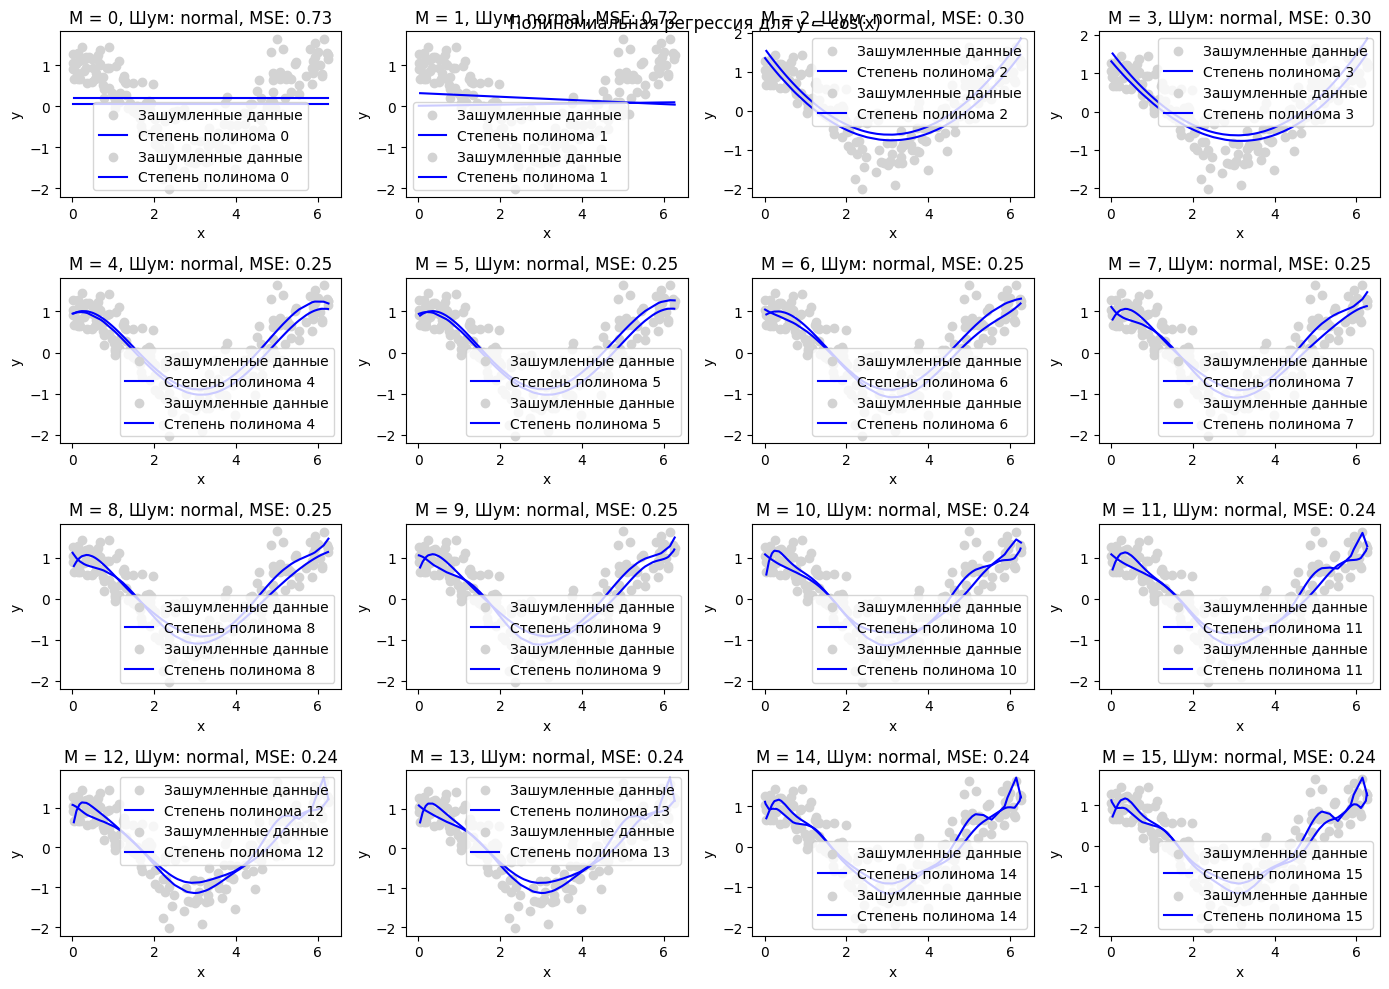

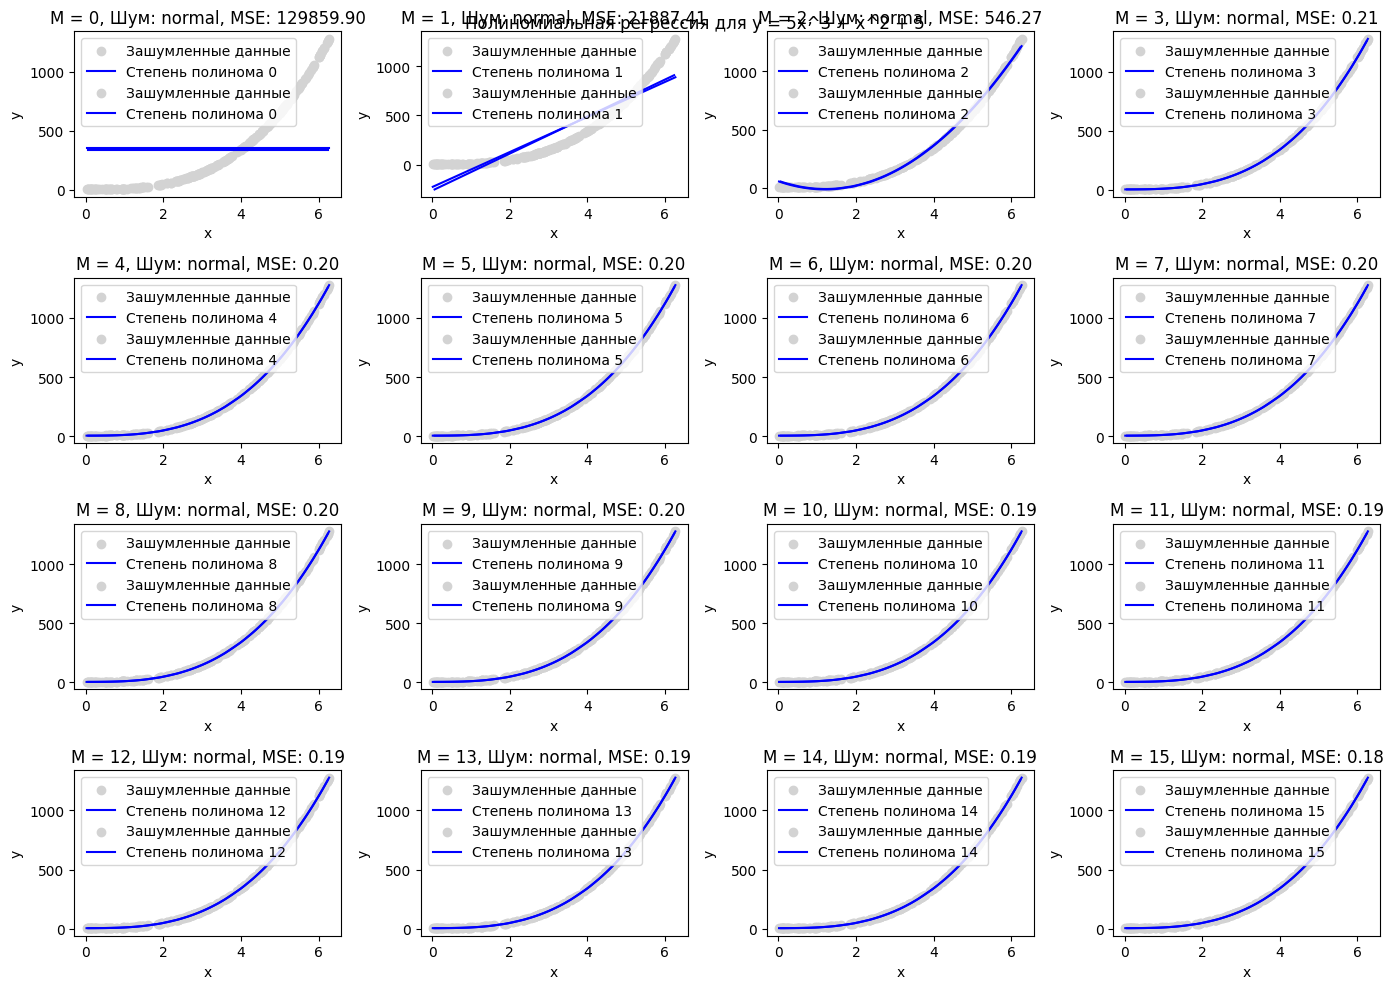

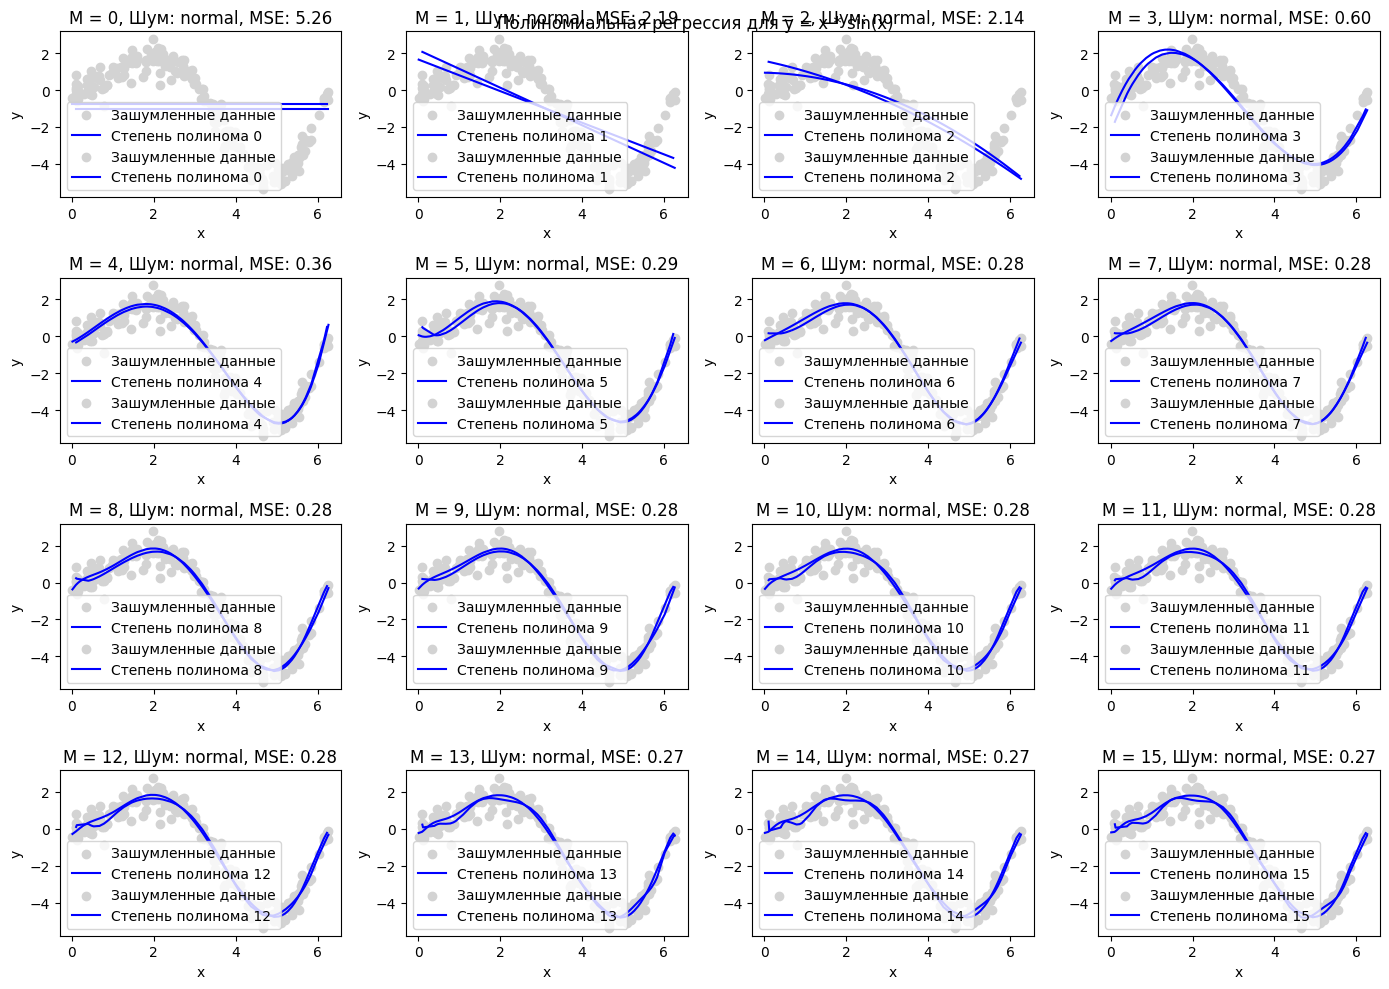

In [13]:
if __name__ == "__main__":
    num_samples = 100
    noise_types = ["uniform", "normal"]

    for func, label in zip(functions, function_labels):
        plt.figure(figsize=(14, 10))
        for noise_type in noise_types:
            x, y_noisy = generate_samples(func, noise_type=noise_type, num_samples=num_samples)

            for M in M_values:
                y_pred, model, X_poly = polynomial_regression(x, y_noisy, degree=M)
                mse = mean_squared_error(y_noisy, y_pred)

                plt.subplot(4, 4, M + 1)
                plt.scatter(x, y_noisy, color='lightgray', label='Зашумленные данные')
                plt.plot(np.sort(x), y_pred[np.argsort(x)], color='blue', label=f'Степень полинома {M}')
                plt.title(f'M = {M}, Шум: {noise_type}, MSE: {mse:.2f}')
                plt.xlabel('x')
                plt.ylabel('y')
                plt.tight_layout()
                plt.legend()

        plt.suptitle(f'Полиномиальная регрессия для {label}')
        plt.show()

## Задание 4

In [6]:
lambda_values = [0.01, 0.1, 1, 10, 100]  # регуляризационные параметры

In [7]:
import warnings

In [8]:
# Полиномиальная регрессия ридж-регрессией
def polynomial_ridge_regression(x, y, degree, alpha):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x[:, np.newaxis])
    model = Ridge(alpha=alpha, solver='lsqr')


    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
        model.fit(X_poly, y)


    y_pred = model.predict(X_poly)
    return y_pred, model, X_poly

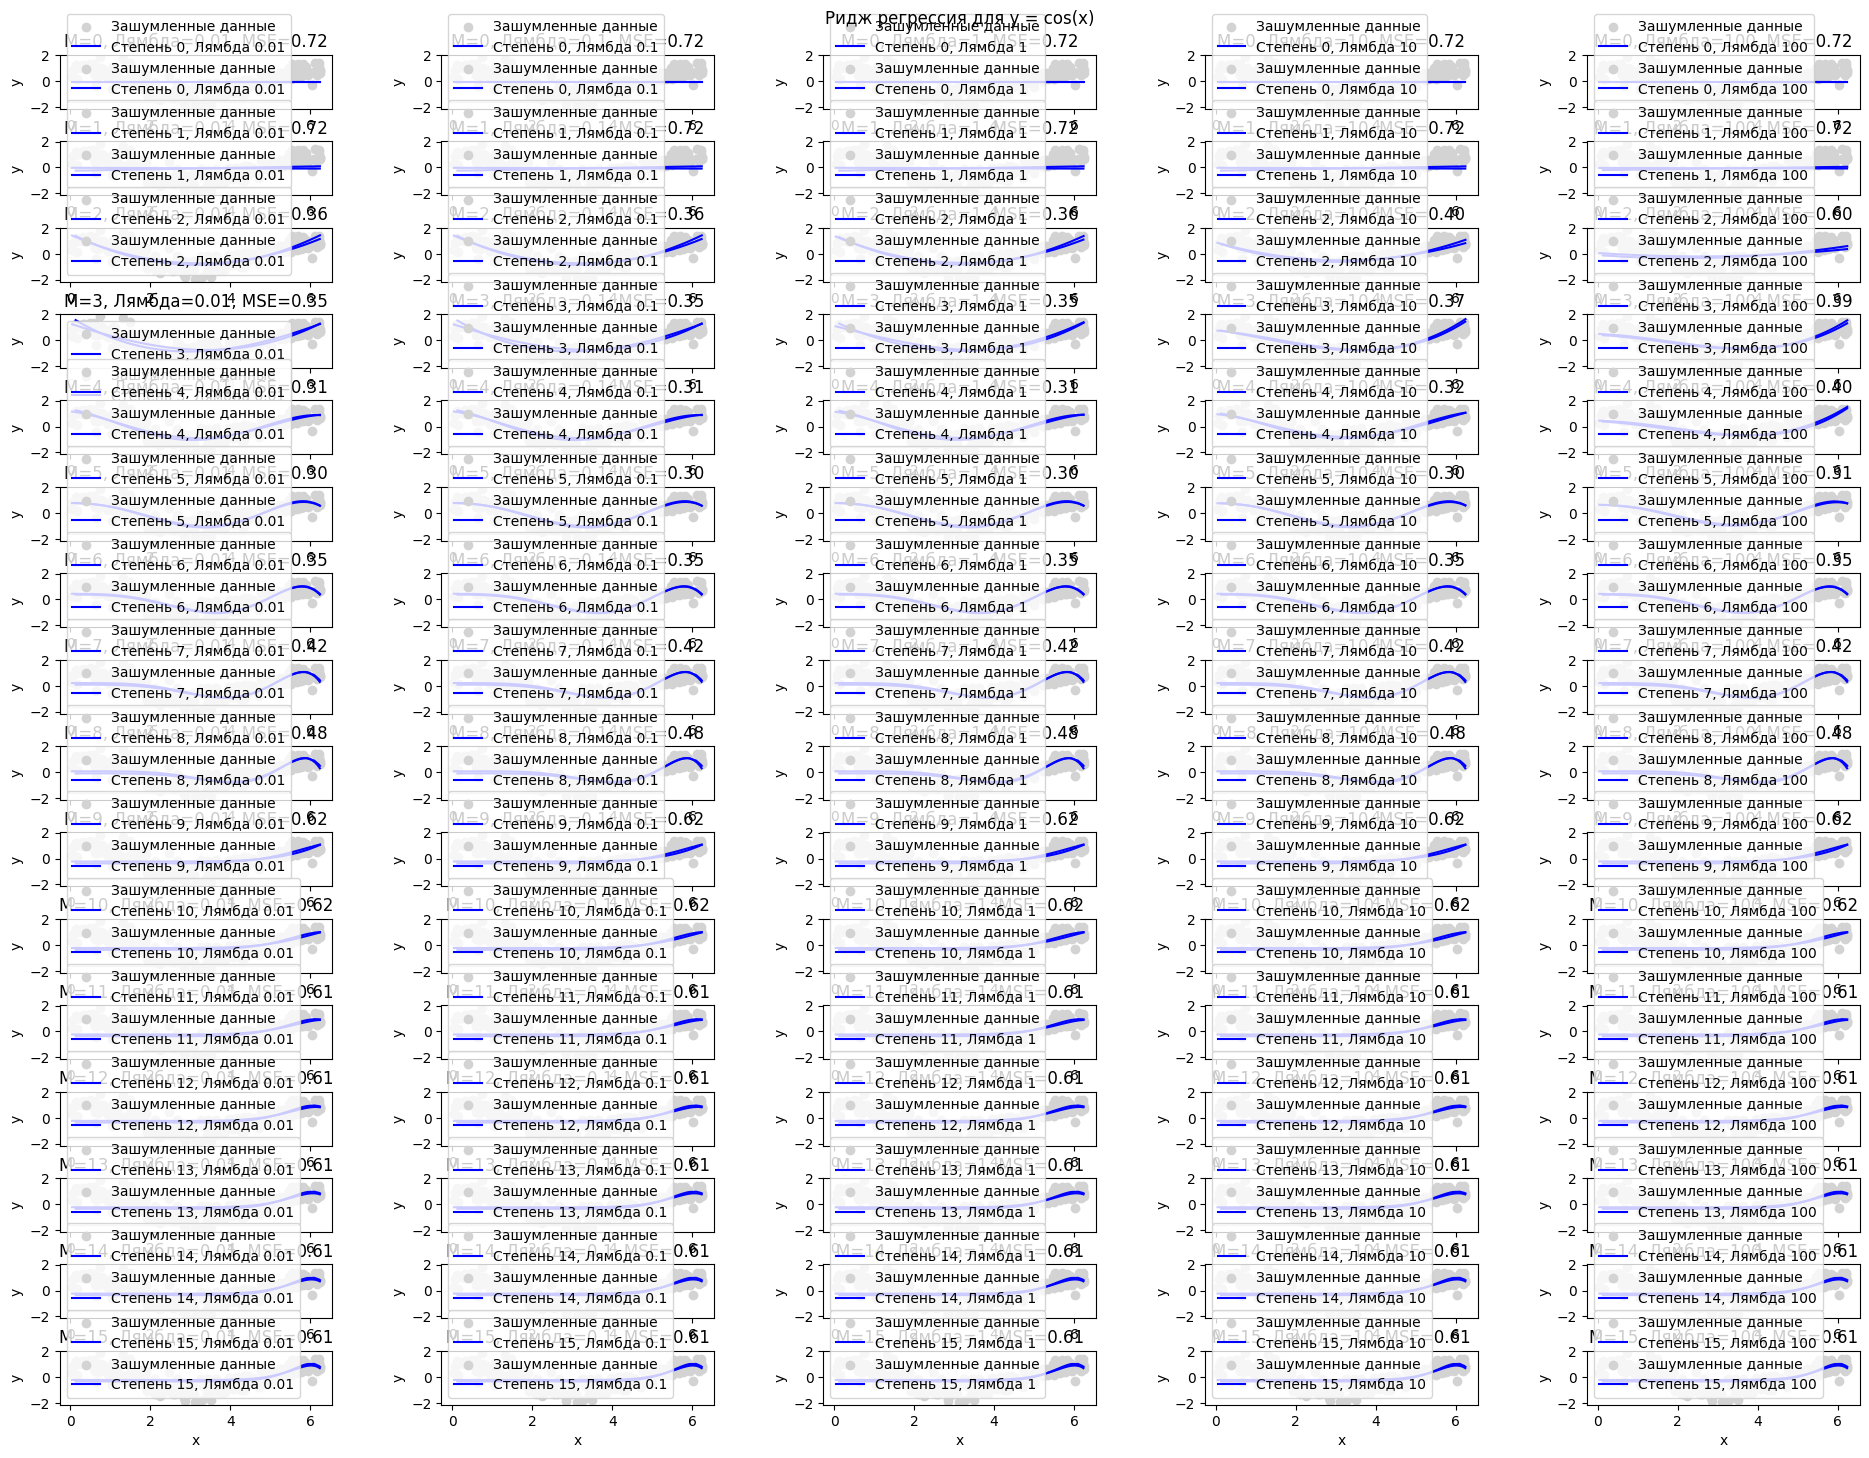

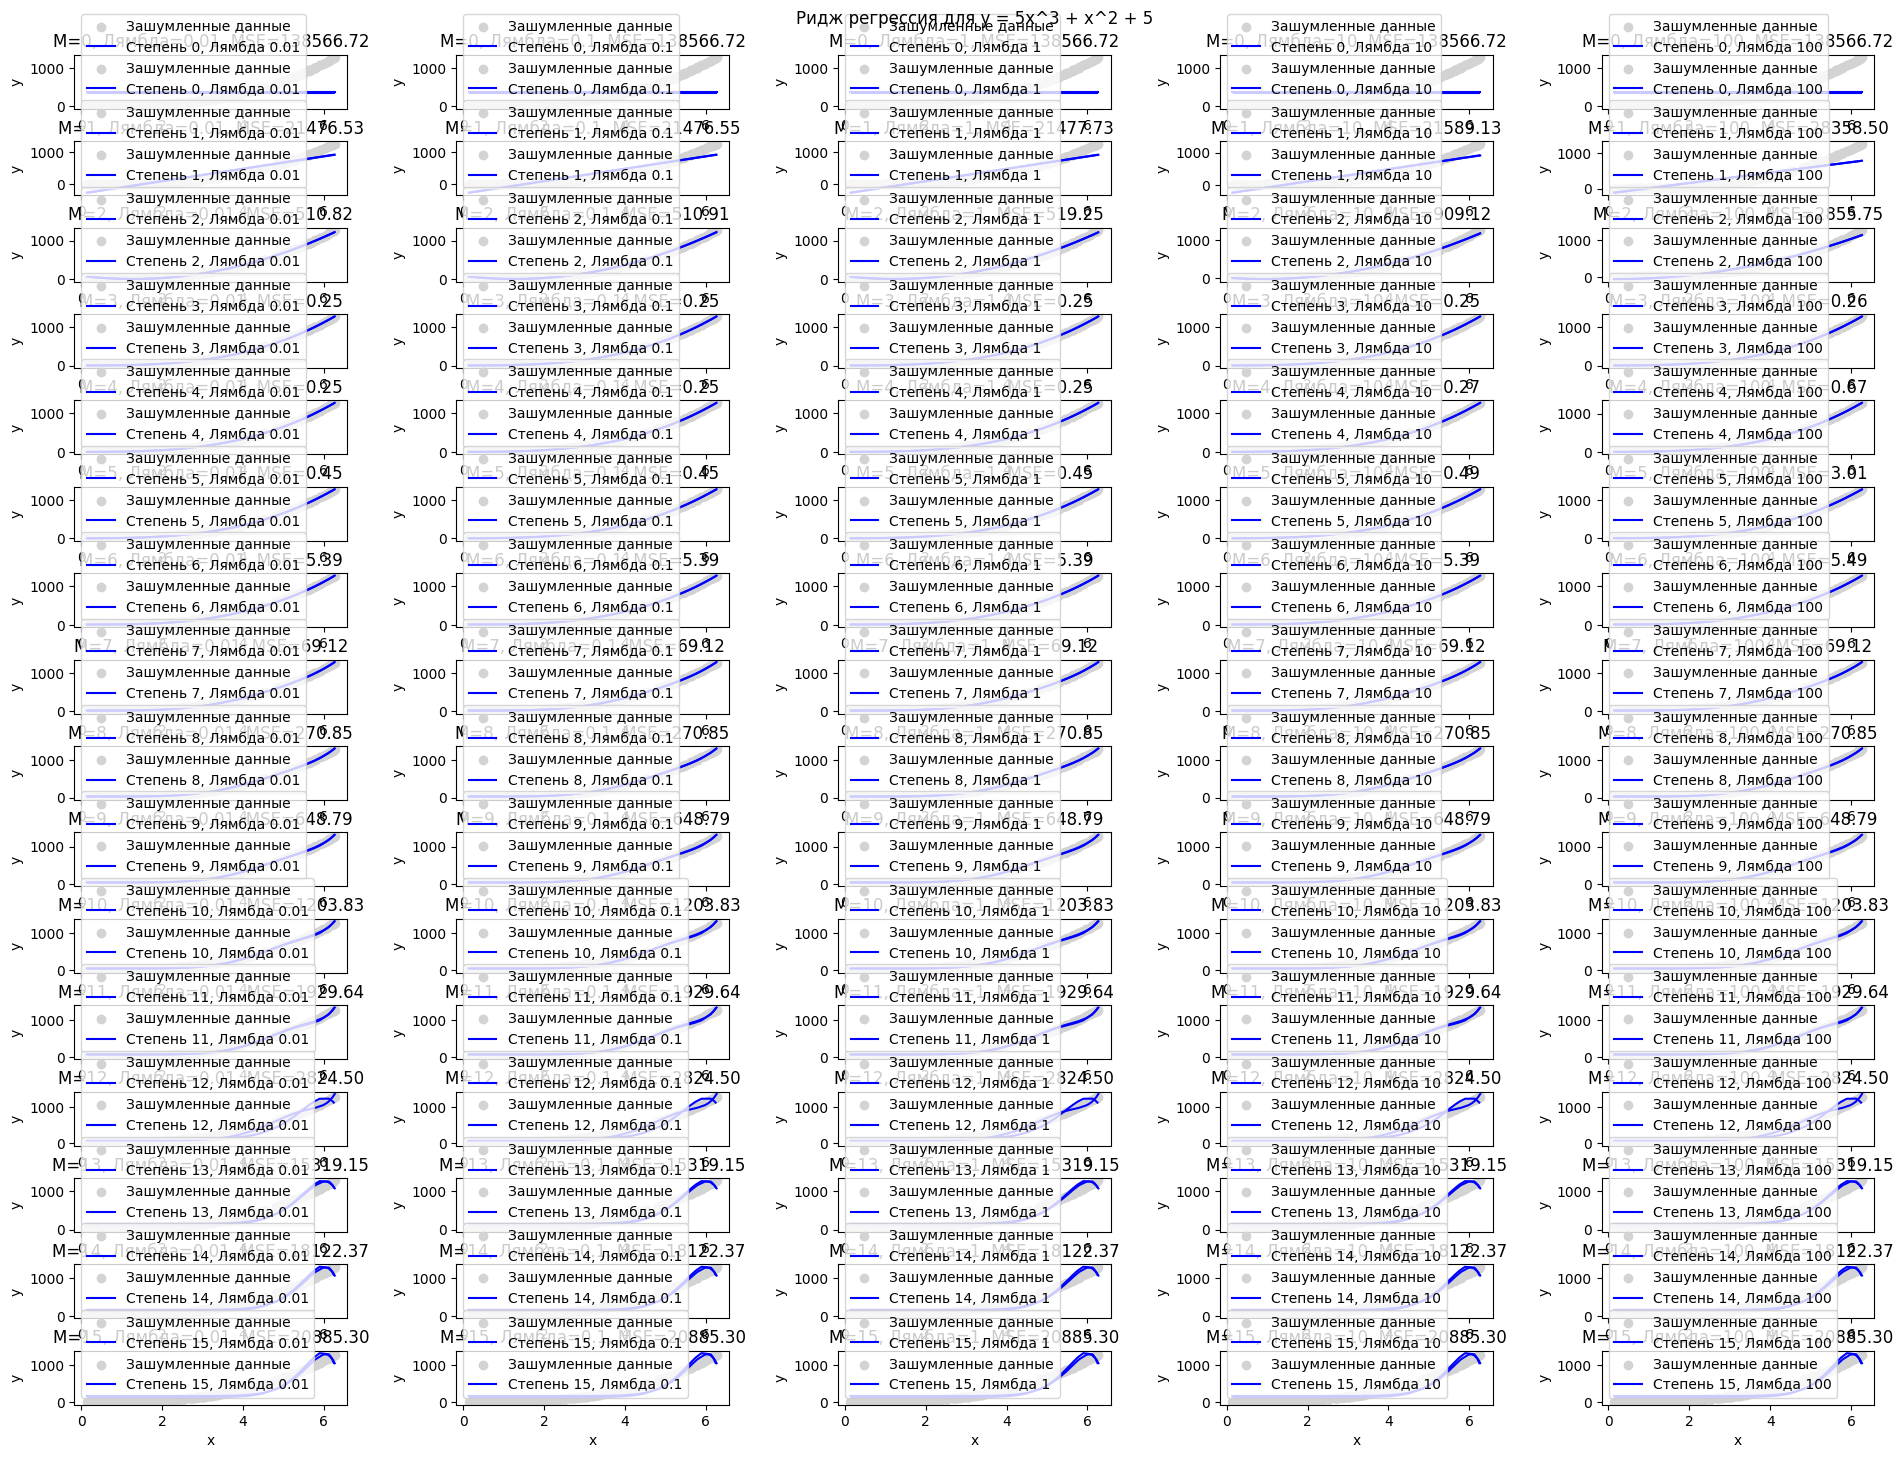

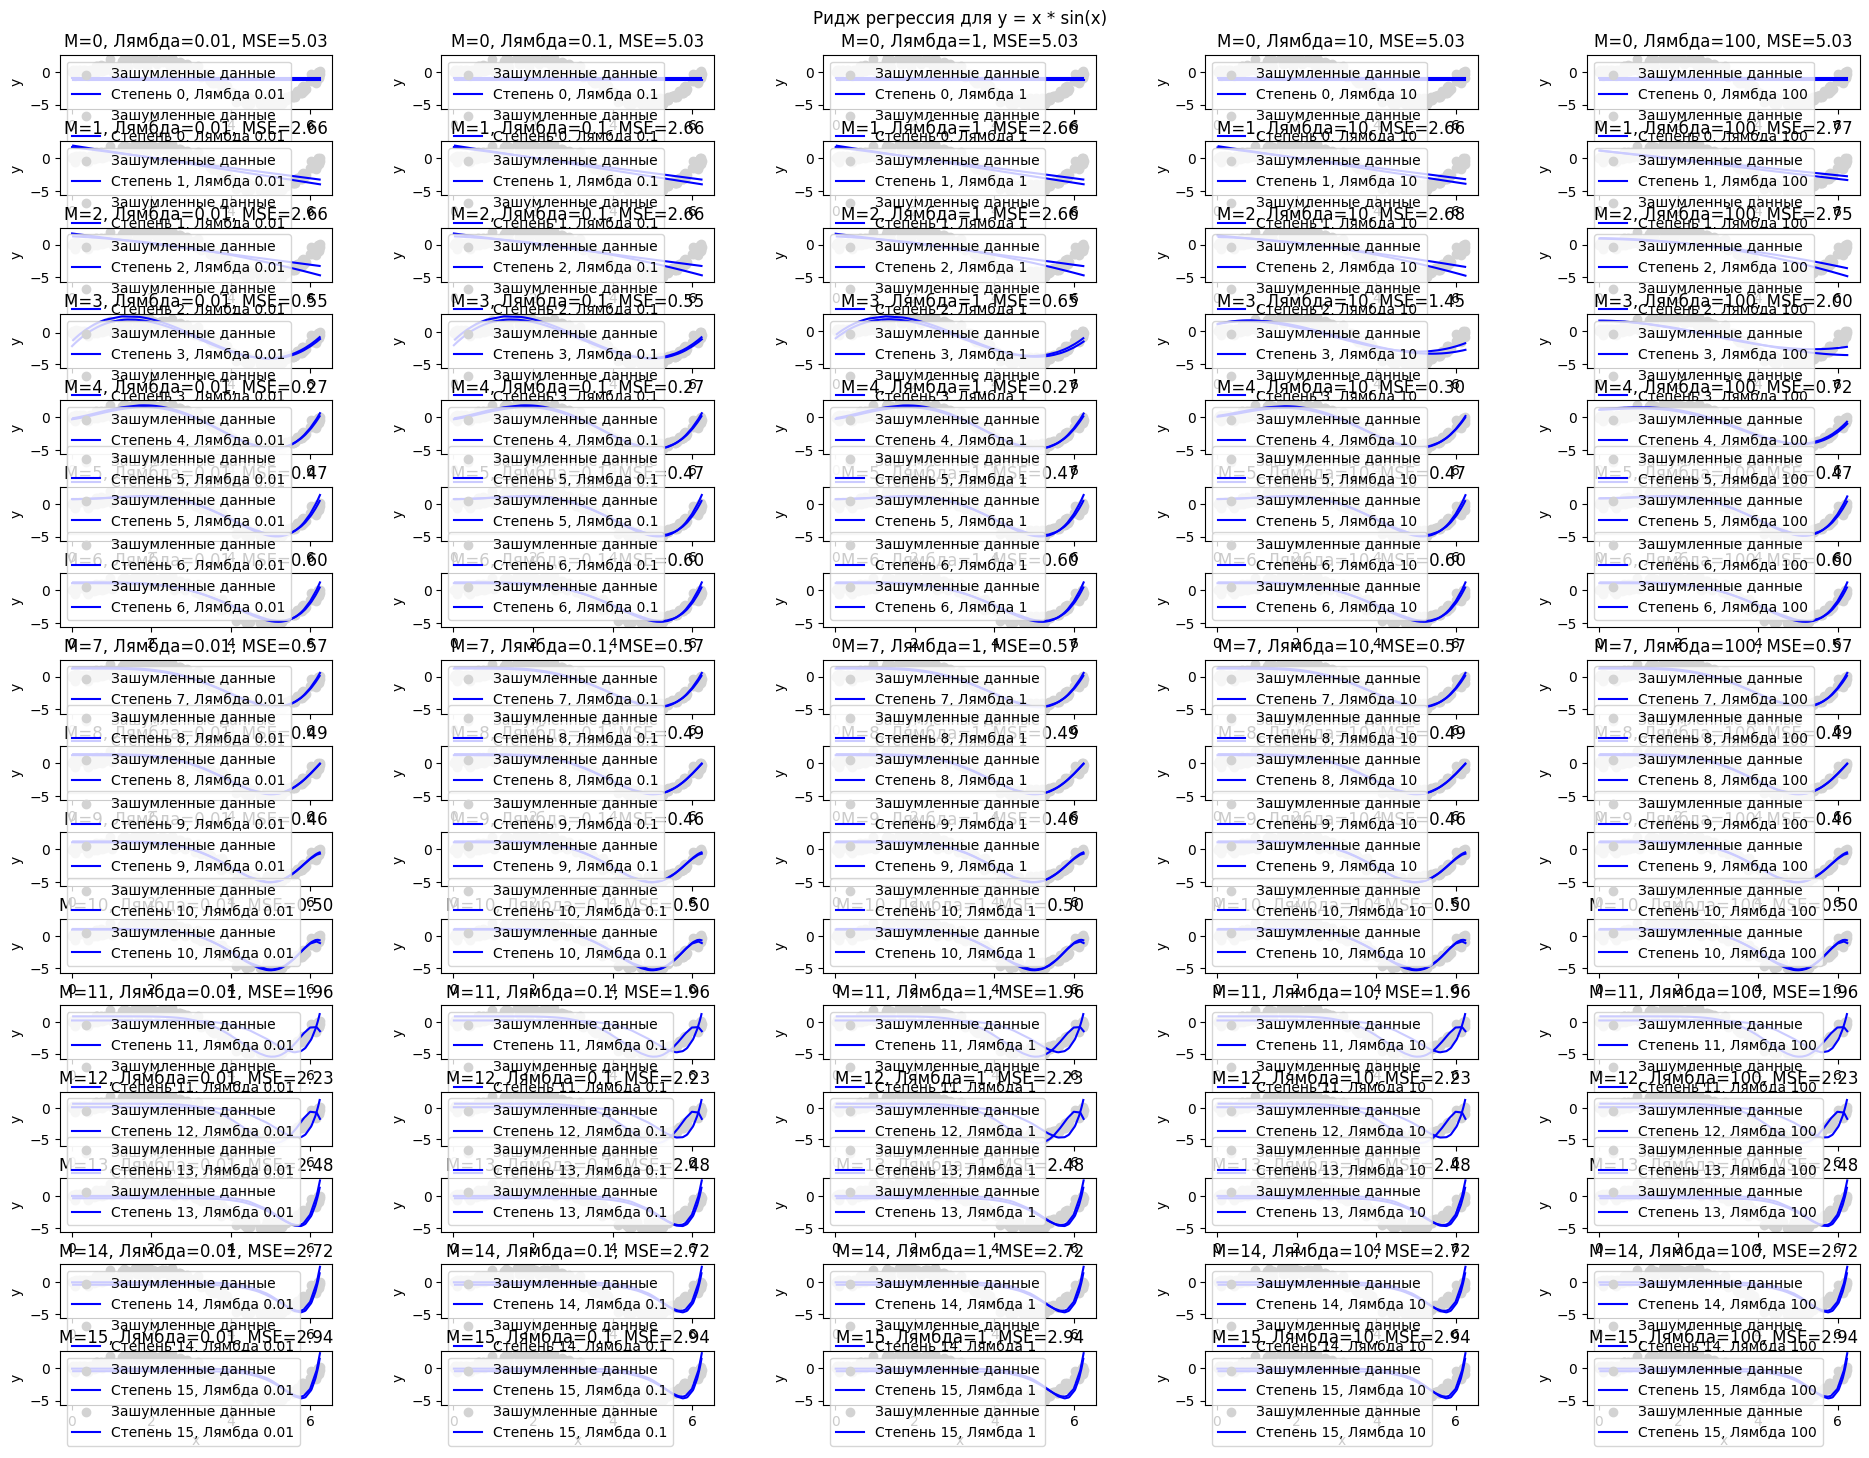

In [10]:
if __name__ == "__main__":
    num_samples = 100
    noise_types = ["uniform", "normal"]

    for func, label in zip(functions, function_labels):
        plt.figure(figsize=(20, 15))
        for noise_type in noise_types:
            x, y_noisy = generate_samples(func, noise_type=noise_type, num_samples=num_samples)

            for M in M_values:
                for alpha in lambda_values:
                    y_pred, model, X_poly = polynomial_ridge_regression(x, y_noisy, degree=M, alpha=alpha)
                    mse = mean_squared_error(y_noisy, y_pred)

                    plt.subplot(len(M_values), len(lambda_values), M * len(lambda_values) + lambda_values.index(alpha) + 1)
                    plt.scatter(x, y_noisy, color='lightgray', label='Зашумленные данные')
                    plt.plot(np.sort(x), y_pred[np.argsort(x)], color='blue', label=f'Степень {M}, Лямбда {alpha}')
                    plt.title(f'M={M}, Лямбда={alpha}, MSE={mse:.2f}')
                    plt.xlabel('x')
                    plt.ylabel('y')
                    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.4, hspace=0.6)
                    plt.legend()

        plt.suptitle(f'Ридж регрессия для {label}')
        plt.show()

## Задание 5

In [11]:
from sklearn.model_selection import KFold

In [12]:
# Кросс-валидация для выбора лучших M и Лямбды
def crossval_ridge(x, y, M_values, lambda_values, n_splits=5):
    best_m = None
    best_lambda = None
    best_mse = float('inf')

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for M in M_values:
        for alpha in lambda_values:
            mse_list = []
            for train_index, test_index in kf.split(x):
                x_train, x_test = x[train_index], x[test_index]
                y_train, y_test = y[train_index], y[test_index]

                y_pred, _, _ = polynomial_ridge_regression(x_train, y_train, degree=M, alpha=alpha)
                X_test_poly = PolynomialFeatures(degree=M).fit_transform(x_test[:, np.newaxis])
                model = Ridge(alpha=alpha, solver='lsqr')
                model.fit(PolynomialFeatures(degree=M).fit_transform(x_train[:, np.newaxis]), y_train)
                y_test_pred = model.predict(X_test_poly)
                mse = mean_squared_error(y_test, y_test_pred)
                mse_list.append(mse)

            avg_mse = np.mean(mse_list)
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_m = M
                best_lambda = alpha

    return best_m, best_lambda, best_mse

Лучший M для y = cos(x) с типом шума uniform: 4, Лучшая Лямбда: 1, MSE: 0.09
Лучший M для y = cos(x) с типом шума normal: 4, Лучшая Лямбда: 0.01, MSE: 0.27


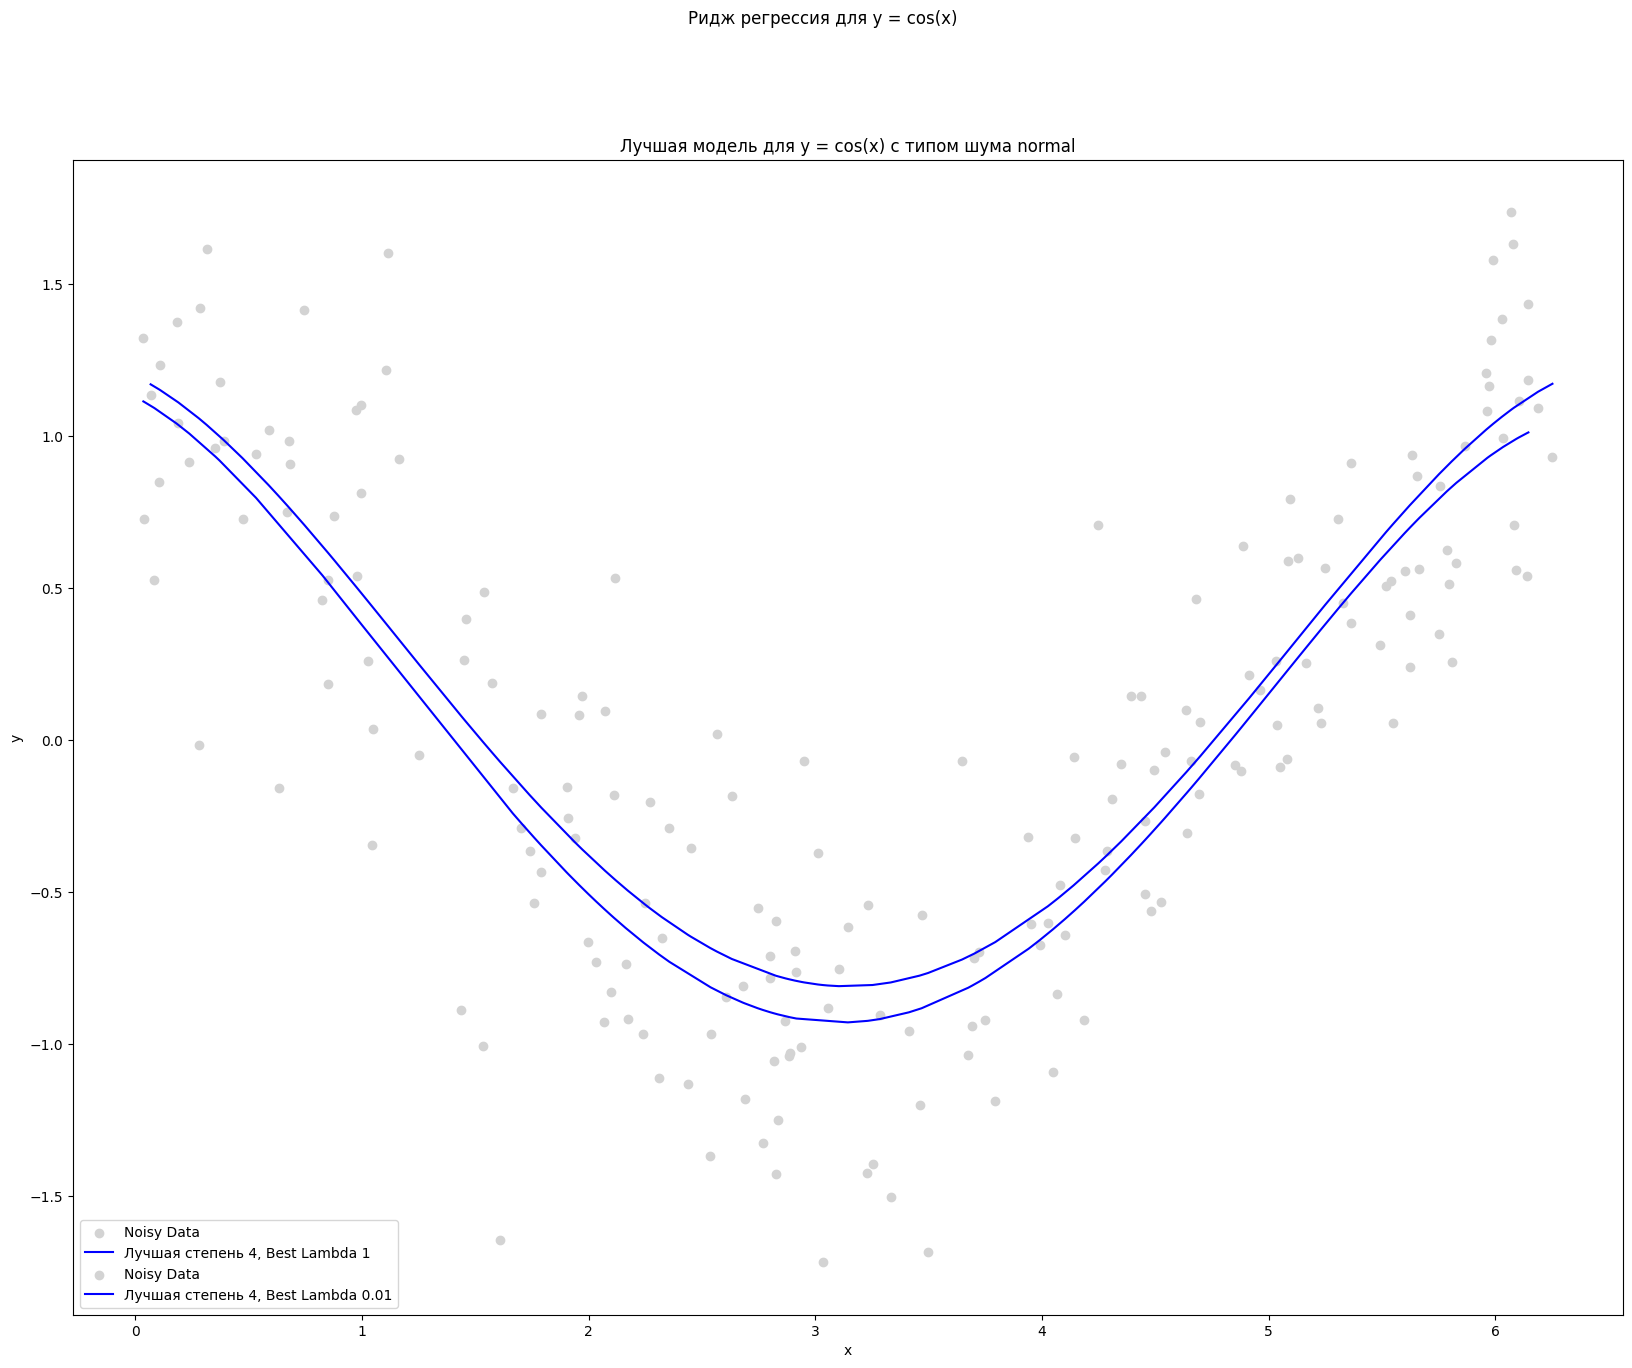

Лучший M для y = 5x^3 + x^2 + 5 с типом шума uniform: 3, Лучшая Лямбда: 1, MSE: 0.08
Лучший M для y = 5x^3 + x^2 + 5 с типом шума normal: 3, Лучшая Лямбда: 0.1, MSE: 0.27


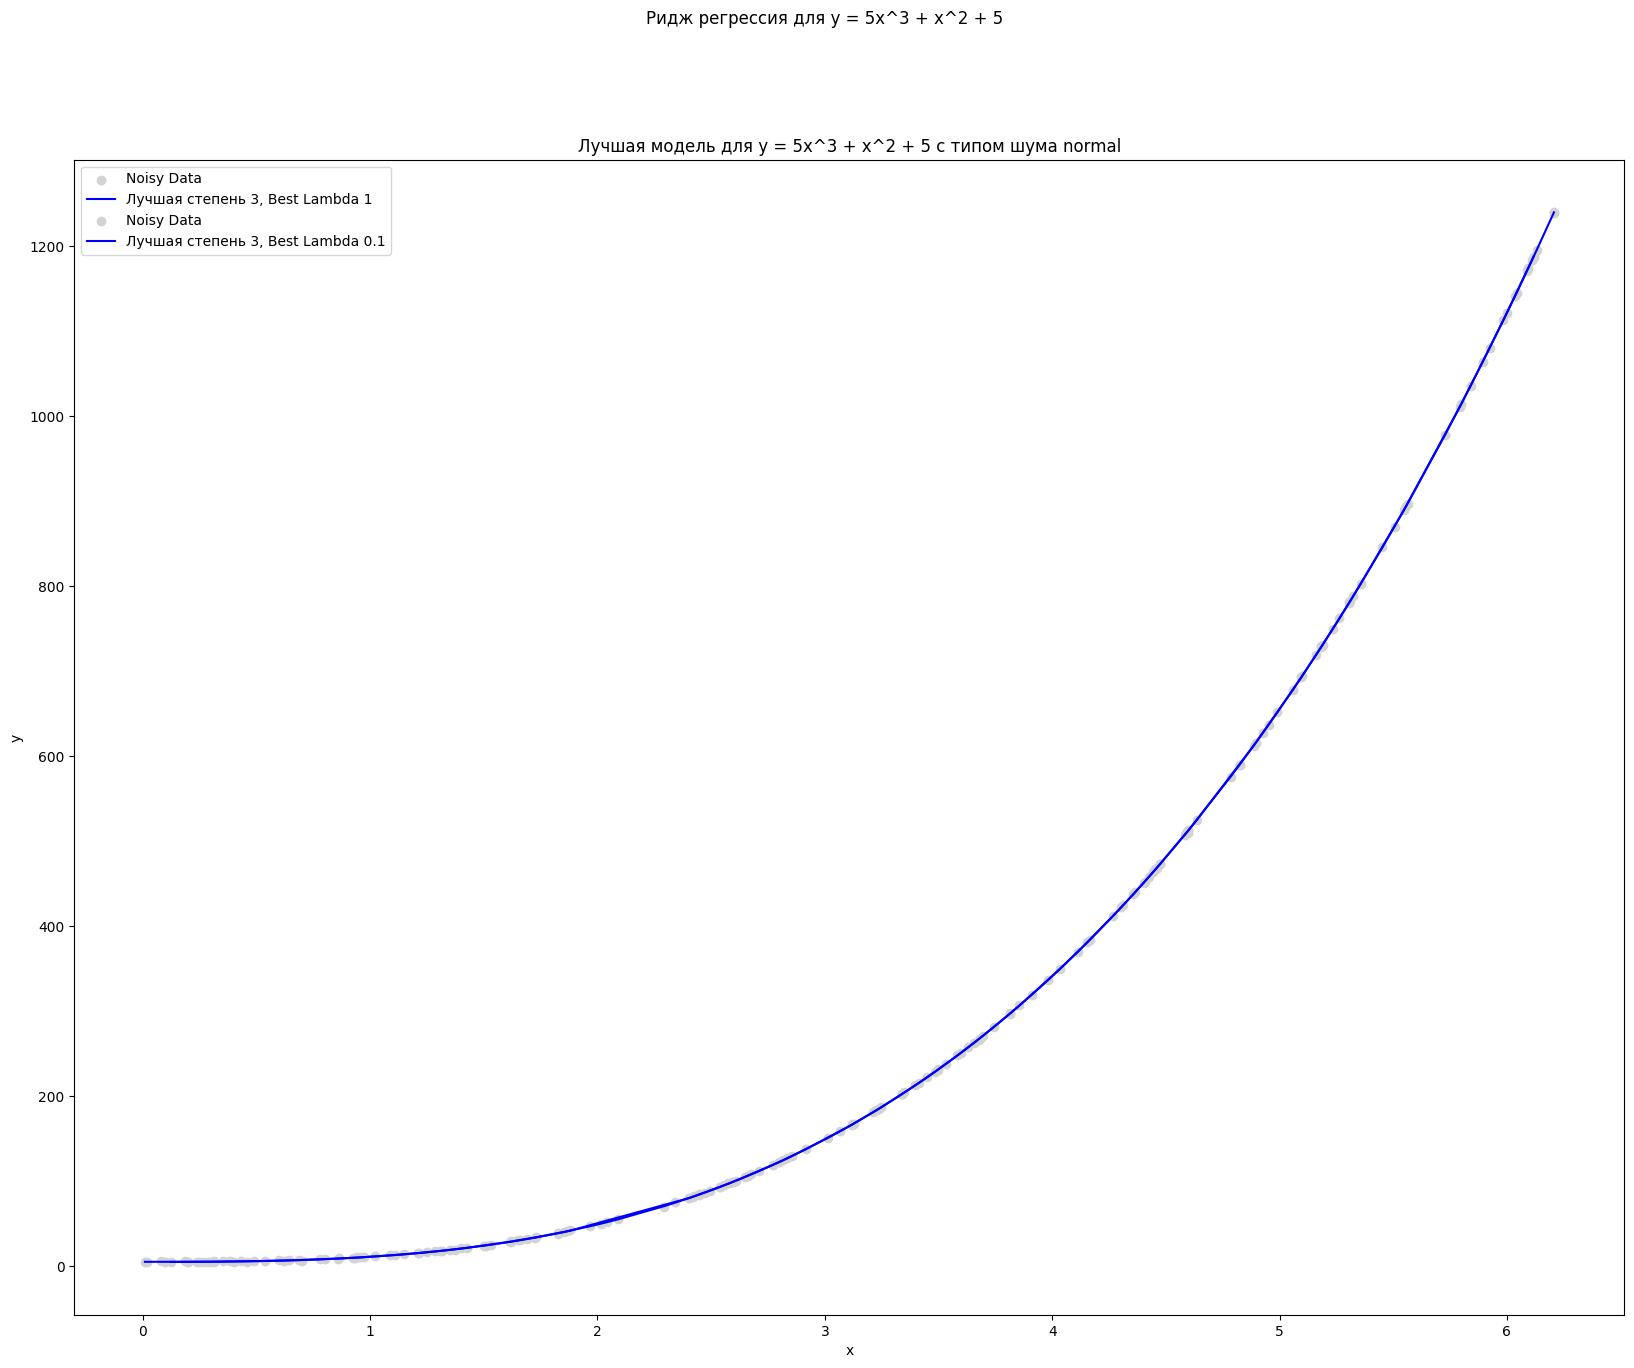

Лучший M для y = x * sin(x) с типом шума uniform: 4, Лучшая Лямбда: 0.1, MSE: 0.14
Лучший M для y = x * sin(x) с типом шума normal: 4, Лучшая Лямбда: 0.01, MSE: 0.27


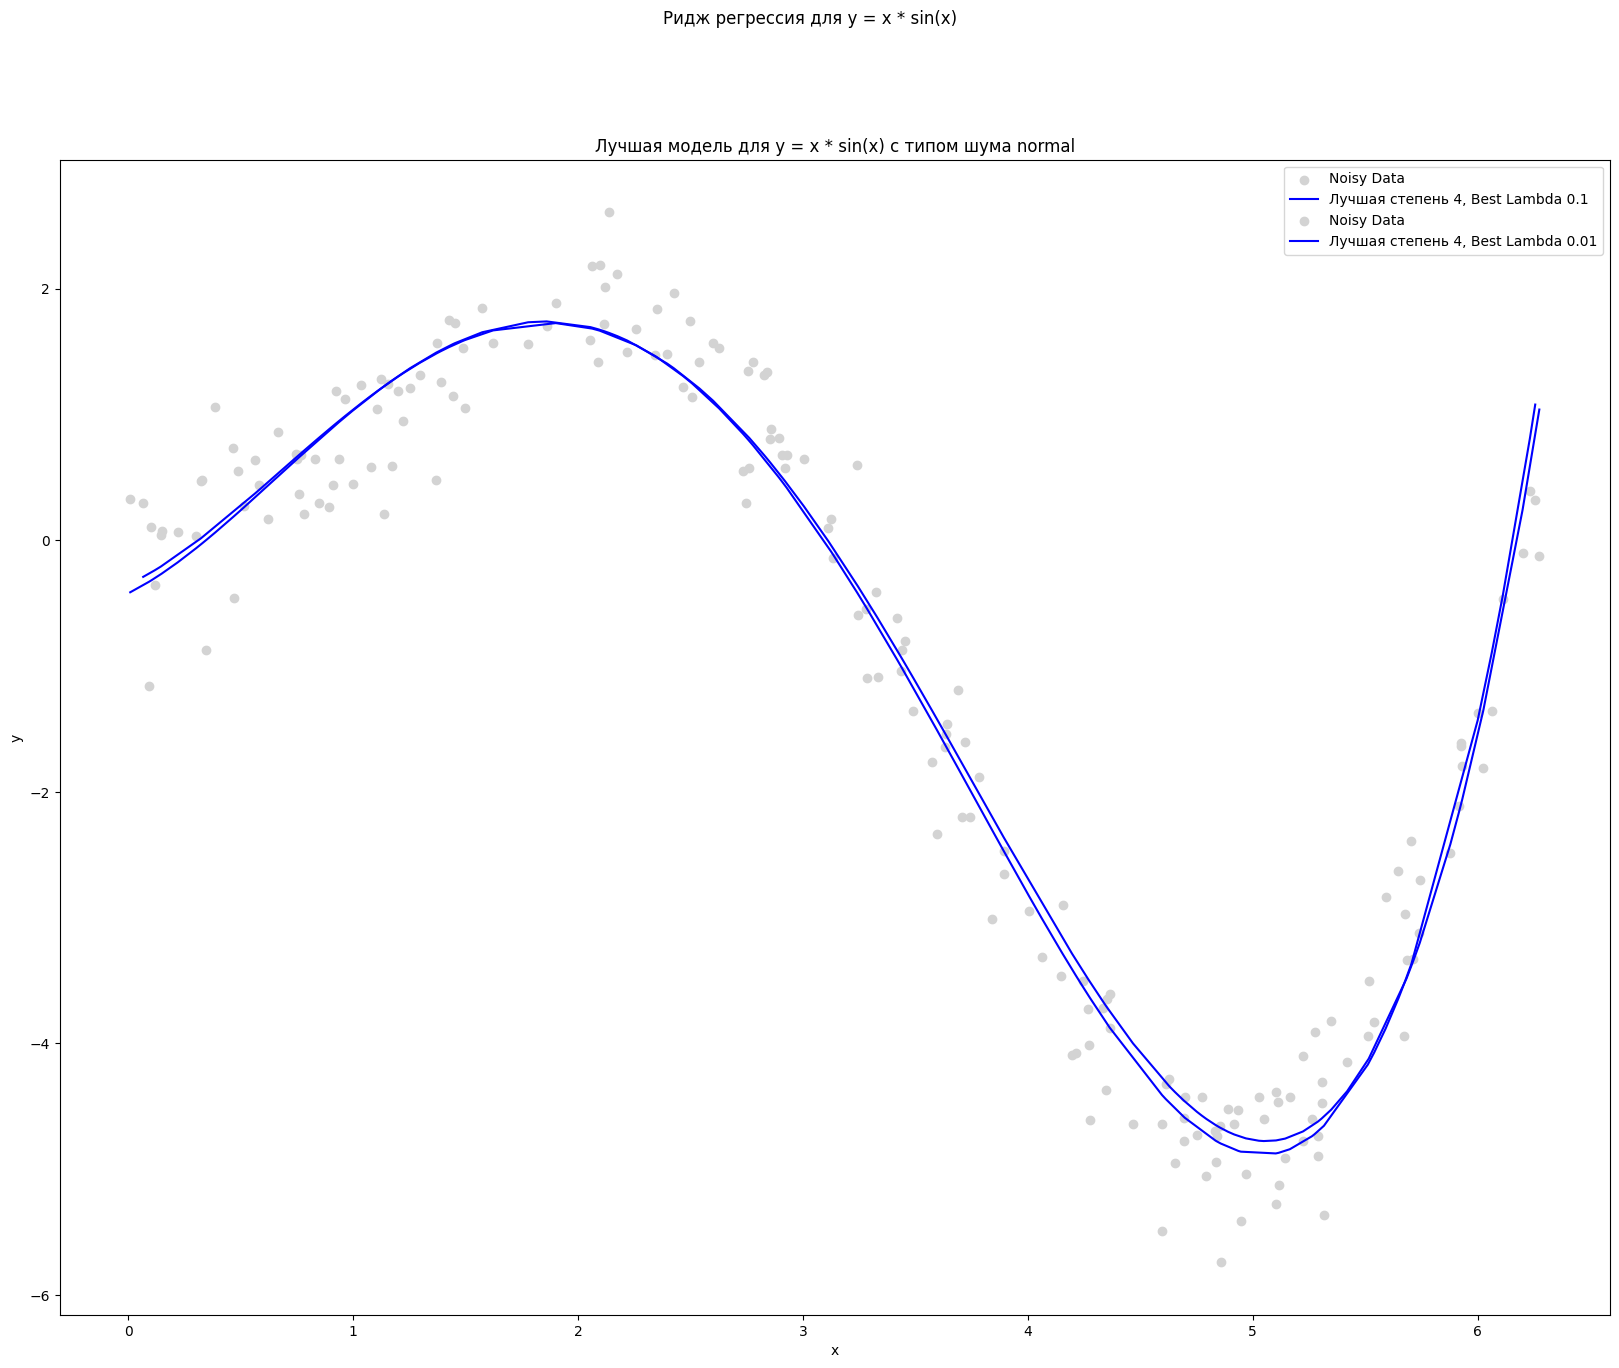

In [14]:
if __name__ == "__main__":
    num_samples = 100
    noise_types = ["uniform", "normal"]

    for func, label in zip(functions, function_labels):
        plt.figure(figsize=(20, 15))
        for noise_type in noise_types:
            x, y_noisy = generate_samples(func, noise_type=noise_type, num_samples=num_samples)

            # Выбор лучших параметров M и lambda
            best_M, best_lambda, best_mse = crossval_ridge(x, y_noisy, M_values, lambda_values)
            print(f'Лучший M для {label} с типом шума {noise_type}: {best_M}, Лучшая Лямбда: {best_lambda}, MSE: {best_mse:.2f}')

            # Обучение
            y_pred, model, X_poly = polynomial_ridge_regression(x, y_noisy, degree=best_M, alpha=best_lambda)

            plt.scatter(x, y_noisy, color='lightgray', label='Noisy Data')
            plt.plot(np.sort(x), y_pred[np.argsort(x)], color='blue', label=f'Лучшая степень {best_M}, Best Lambda {best_lambda}')
            plt.title(f'Лучшая модель для {label} с типом шума {noise_type}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend()

        plt.suptitle(f'Ридж регрессия для {label}')
        plt.show()
